In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/target-dataset/products.csv
/kaggle/input/target-dataset/geolocation.csv
/kaggle/input/target-dataset/order_items.csv
/kaggle/input/target-dataset/orders.csv
/kaggle/input/target-dataset/customers.csv
/kaggle/input/target-dataset/sellers.csv
/kaggle/input/target-dataset/payments.csv


In [2]:
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# Define CSV files and table names with full paths
csv_files = {
    "/kaggle/input/target-dataset/customers.csv": "customers",
    "/kaggle/input/target-dataset/geolocation.csv": "geolocation",
    "/kaggle/input/target-dataset/order_items.csv": "order_items",
    "/kaggle/input/target-dataset/orders.csv": "orders",
    "/kaggle/input/target-dataset/payments.csv": "payments",
    "/kaggle/input/target-dataset/products.csv": "products",
    "/kaggle/input/target-dataset/sellers.csv": "sellers"
}

# Connect to (or create) SQLite database
db = sqlite3.connect('ecommerce_data.db')

# Loop through each CSV and import into SQLite
for file_path, table_name in csv_files.items():
    try:
        df = pd.read_csv(file_path)
        df.to_sql(table_name, con=db, if_exists='replace', index=False)
        print(f"✅ Imported '{file_path}' into table '{table_name}'")
    except Exception as e:
        print(f"❌ Failed to import '{file_path}': {e}")


✅ Imported '/kaggle/input/target-dataset/customers.csv' into table 'customers'
✅ Imported '/kaggle/input/target-dataset/geolocation.csv' into table 'geolocation'
✅ Imported '/kaggle/input/target-dataset/order_items.csv' into table 'order_items'
✅ Imported '/kaggle/input/target-dataset/orders.csv' into table 'orders'
✅ Imported '/kaggle/input/target-dataset/payments.csv' into table 'payments'
✅ Imported '/kaggle/input/target-dataset/products.csv' into table 'products'
✅ Imported '/kaggle/input/target-dataset/sellers.csv' into table 'sellers'


In [3]:
cur = db.cursor()

## List all unique cities where customers are located.

In [4]:
query = """ SELECT DISTINCT customer_city from customers """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


## Count the number of orders placed in 2017

In [5]:
query = """
SELECT COUNT(order_id)
FROM orders
WHERE strftime('%Y', order_purchase_timestamp) = '2017'
"""

cur.execute(query)
data = cur.fetchall()
print("📦 Total orders placed in 2017 are:", data[0][0])


📦 Total orders placed in 2017 are: 45101


# Find the total sales per category.

In [6]:
query = """
SELECT products."product category" AS category,
       SUM(payments.payment_value) AS sales 
FROM products 
JOIN order_items ON products.product_id = order_items.product_id 
JOIN payments ON payments.order_id = order_items.order_id
GROUP BY products."product category"

"""


cur.execute(query)
data = cur.fetchall()

In [7]:
df = pd.DataFrame(data, columns= ['Category', 'Sales'])
df

,Category,Sales
0,None,252801.71
1,Agro Industria e Comercio,118730.61
2,Art,30992.93
3,Arts and Crafts,2326.17
4,Bags Accessories,187151.29
...,...,...
69,sport leisure,1392127.56
70,stationary store,317440.07
71,technical books,24915.44
72,telephony,486882.05


## Calculate the percentage of orders that were paid in installments.

In [8]:

query = """
SELECT 
  100.0 * SUM(CASE WHEN payment_installments >= 1 THEN 1 ELSE 0 END) / COUNT(*) AS installment_percentage
FROM payments;
"""

cur.execute(query)

data = cur.fetchall()

"the percentage of orders that were paid in installments is", data[0][0]

('the percentage of orders that were paid in installments is',
 99.99807481277554)

## Count the number of customers from each state. 

In [9]:
query = """ 

SELECT customer_state, COUNT(customer_id)
FROM customers 
GROUP BY customer_state

"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns= ["state", "customer_count"])
df = df.sort_values(by= 'customer_count', ascending=False)


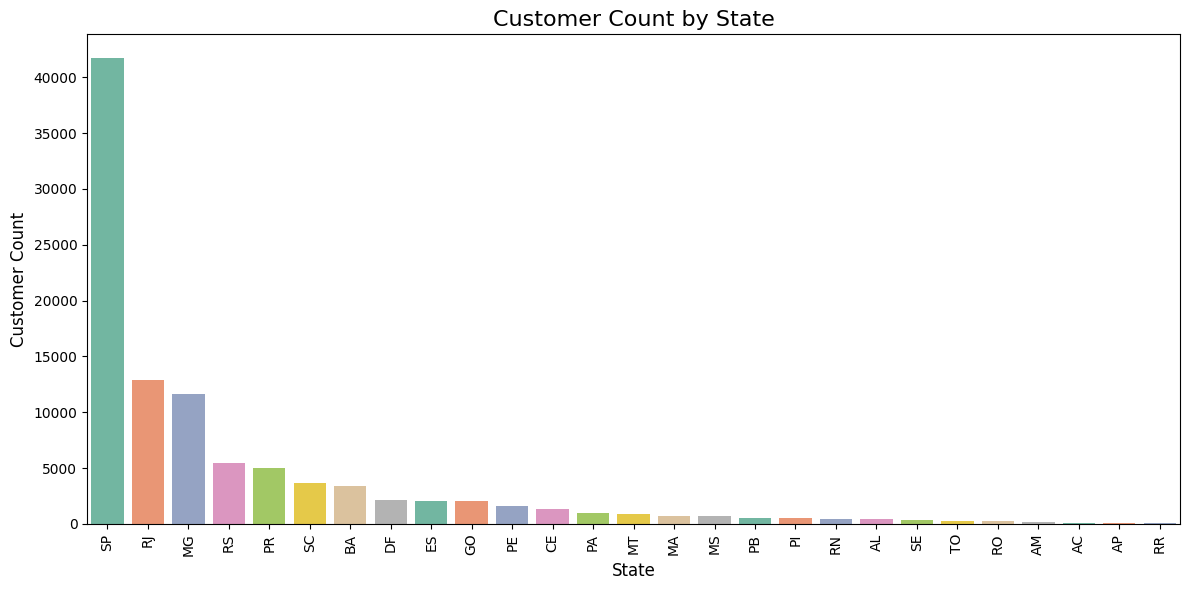

In [10]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x='state',
    y='customer_count',
    hue='state',  
    data=df,
    palette='Set2',
    dodge=False
)

plt.xticks(rotation=90)
plt.title("Customer Count by State", fontsize=16)
plt.xlabel("State", fontsize=12)
plt.ylabel("Customer Count", fontsize=12)
ax.get_legend().remove()  # <-- Removes legend properly
plt.tight_layout()
plt.show()

## Intermediate Queries

## Calculate the number of orders per month in 2018.

In [11]:
query = """
SELECT strftime('%m', order_purchase_timestamp) AS month_num,
       COUNT(order_id) AS order_count
FROM orders
WHERE strftime('%Y', order_purchase_timestamp) = '2018'
GROUP BY month_num
ORDER BY month_num
"""

cur.execute(query)
data = cur.fetchall()

# Create DataFrame
df = pd.DataFrame(data, columns=["months", "order_count"])

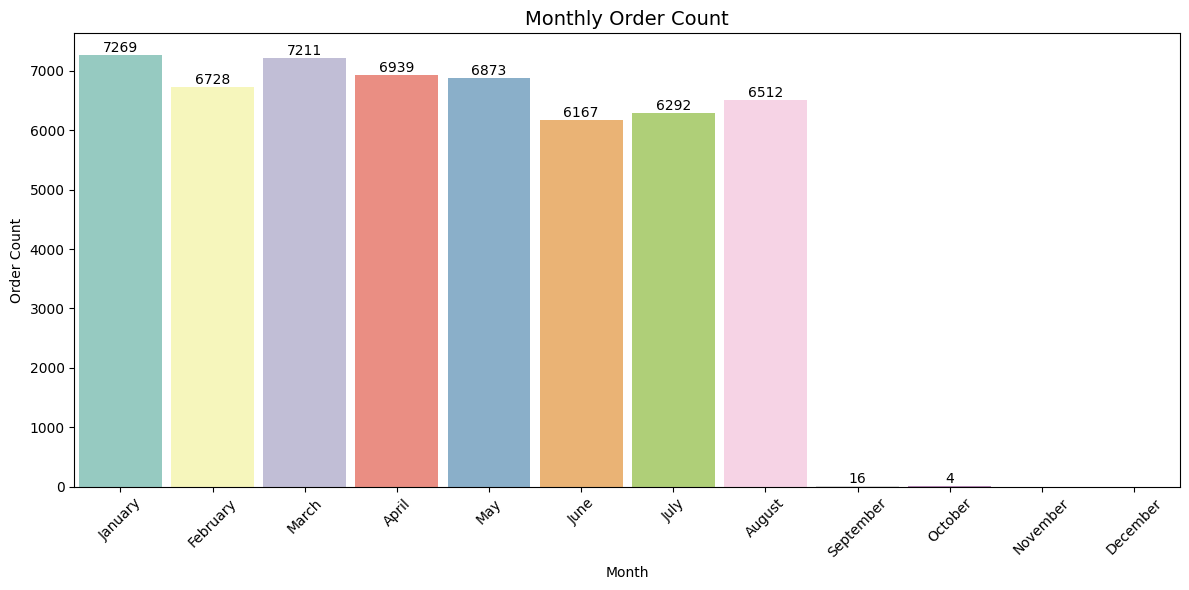

In [12]:

# Create DataFrame
df = pd.DataFrame(data, columns=["months", "order_count"])

# Map month numbers to month names
month_map = {
    "01": "January", "02": "February", "03": "March", "04": "April",
    "05": "May", "06": "June", "07": "July", "08": "August",
    "09": "September", "10": "October", "11": "November", "12": "December"
}
df["months"] = df["months"].map(month_map)

# Define month order for plotting
month_order = ["January", "February", "March", "April", "May", "June",
               "July", "August", "September", "October", "November", "December"]

# Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x='months',
    y='order_count',
    data=df,
    order=month_order,
    palette='Set3',
    width=0.9  # ✅ Correct width
)

# Optional: Hide legend (no hue, so no legend anyway)
# ax.legend_.remove()

plt.xticks(rotation=45)
plt.title("Monthly Order Count", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Order Count")

# Label each bar
for container in ax.containers:
    ax.bar_label(container)

plt.tight_layout()
plt.show()

## Find the average number of products per order, grouped by customer city.

In [13]:
query = """ 

WITH count_per_order AS
(SELECT orders.order_id, orders.customer_id, COUNT(order_items.order_id) AS oc
FROM orders JOIN order_items
ON orders.order_id = order_items.order_id
GROUP BY orders.order_id, orders.customer_id)

SELECT customers.customer_city, round(avg(count_per_order.oc),2) average_orders
FROM customers JOIN count_per_order
ON customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc;



"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns=["customer city", "average products/orders"])


In [14]:
df.head(10)

,customer city,average products/orders
0,padre carvalho,7.0
1,celso ramos,6.5
2,datas,6.0
3,candido godoi,6.0
4,matias olimpio,5.0
5,teixeira soares,4.0
6,picarra,4.0
7,morro de sao paulo,4.0
8,curralinho,4.0
9,cidelandia,4.0


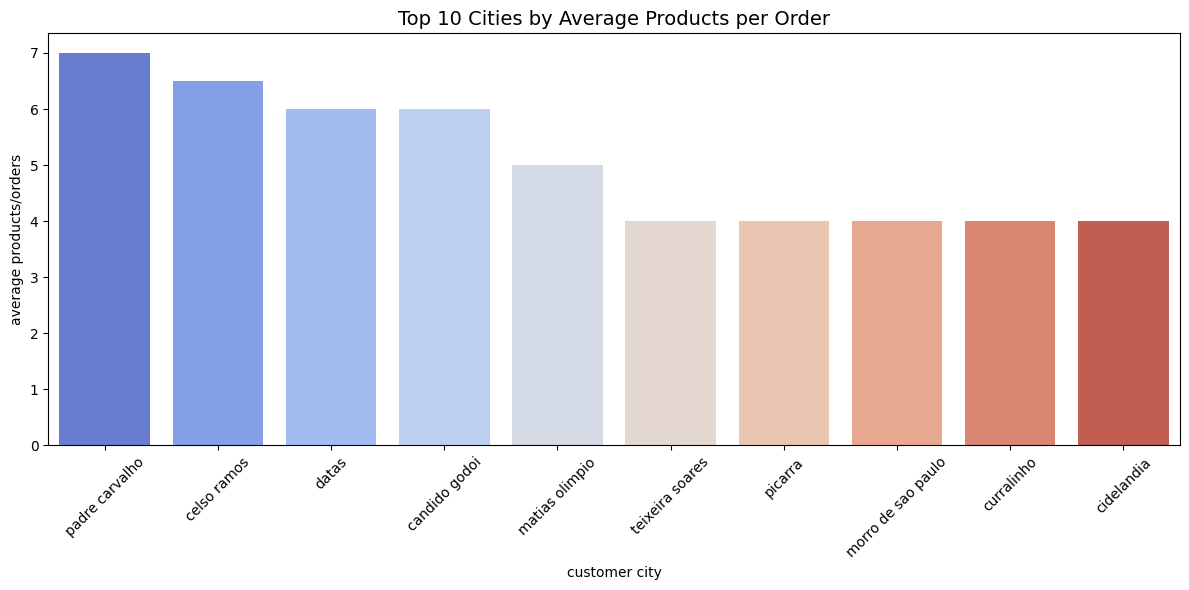

In [15]:
# Show top 10 cities
top_cities = df.head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x='customer city', y='average products/orders', data=top_cities, palette='coolwarm')
plt.title("Top 10 Cities by Average Products per Order", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Calculate the percentage of total revenue contributed by each product category.

In [16]:
query = """ 

SELECT upper(products.`product category`) AS category, 
       ROUND((SUM(payments.payment_value)/(select sum(payment_value) from payments))*100, 2) AS sales_percentage
FROM products 
JOIN order_items ON products.product_id = order_items.product_id 
JOIN payments ON payments.order_id = order_items.order_id
GROUP BY products.`product category` order by sales_percentage desc;

"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns= ["Category", "percentage distribution"])
df.head(10)



,Category,percentage distribution
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,WATCHES PRESENT,8.93
4,FURNITURE DECORATION,8.93
5,SPORT LEISURE,8.70
6,HOUSEWARES,6.84
7,AUTOMOTIVE,5.32
8,GARDEN TOOLS,5.24
9,COOL STUFF,4.87


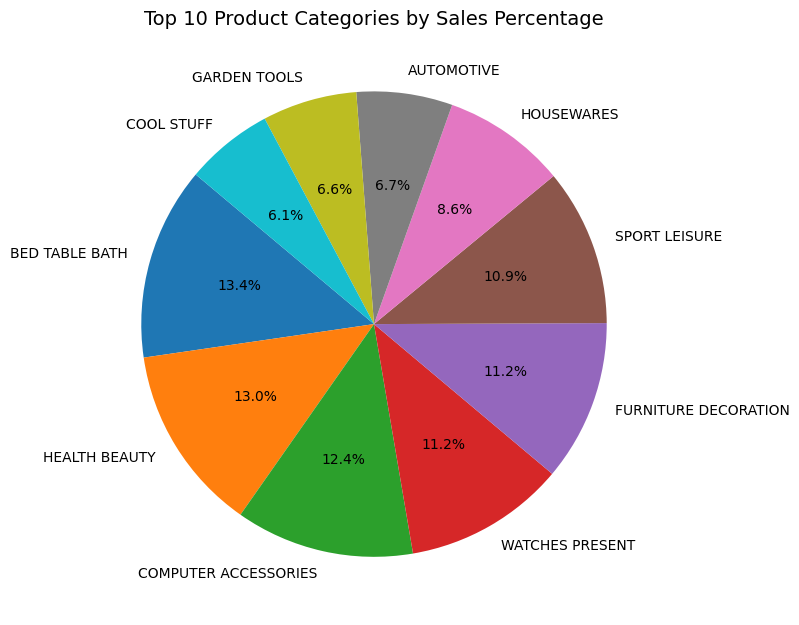

In [17]:
# Top 10 categories
top10 = df.head(10)

# Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(top10["percentage distribution"], labels=top10["Category"], autopct="%1.1f%%", startangle=140)
plt.title("Top 10 Product Categories by Sales Percentage", fontsize=14)
plt.tight_layout()
plt.show()


## Identify the correlation between product price and the number of times a product has been purchased.

In [18]:
query = """

SELECT products.`product category`,
COUNT(order_items.product_id),
ROUND(avg(order_items.price),2)
FROM products JOIN order_items
ON products.product_id = order_items.product_id
GROUP BY products.`product category`

"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns= ["Category", "order_count", "price"])

In [19]:
print(df.columns.tolist())

['Category', 'order_count', 'price']


In [20]:
arr1 = df["order_count"]
arr2 = df["price"]

np.corrcoef([arr1,arr2])

array([[ 1.        , -0.10631626],
       [-0.10631626,  1.        ]])

- No correlation showing

In [21]:
a = np.corrcoef([arr1,arr2])
print("the correlation between price and number of times a product has been purchased is", a[0][1])

the correlation between price and number of times a product has been purchased is -0.106316258238607


In [22]:
df

,Category,order_count,price
0,None,1603,112.00
1,Agro Industria e Comercio,212,342.12
2,Art,209,115.80
3,Arts and Crafts,24,75.58
4,Bags Accessories,1092,128.60
...,...,...,...
69,sport leisure,8641,114.34
70,stationary store,2517,91.75
71,technical books,267,71.52
72,telephony,4545,71.21


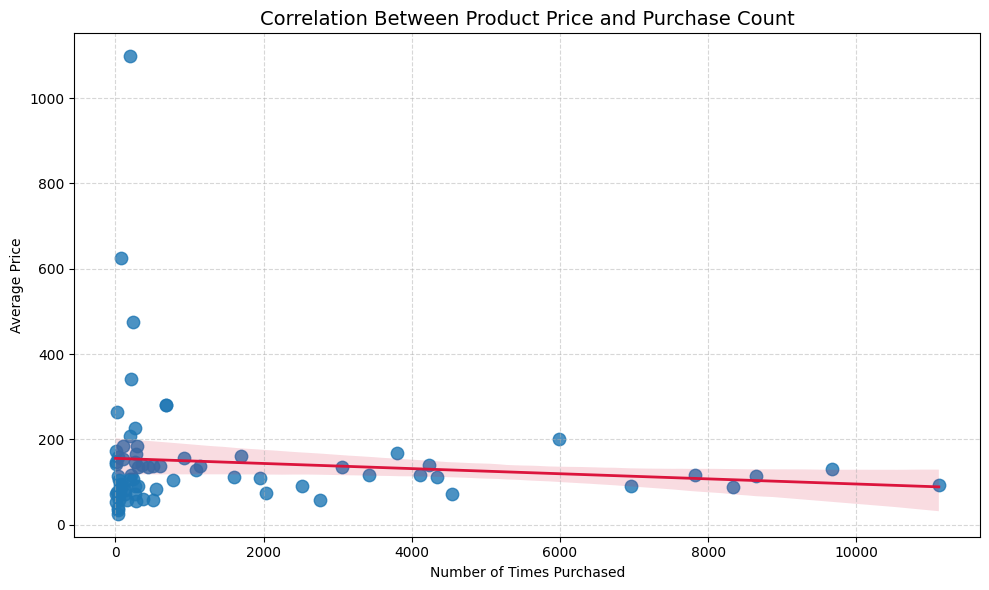

In [23]:
plt.figure(figsize=(10, 6))
sns.regplot(
    x='order_count',
    y='price',
    data=df,
    scatter_kws={'s': 80, 'color': '#1f77b4'},  # Customize size and color of points
    line_kws={"color": "crimson", "linewidth": 2}  # Customize regression line
)
plt.title("Correlation Between Product Price and Purchase Count", fontsize=14)
plt.xlabel("Number of Times Purchased")
plt.ylabel("Average Price")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Calculate the total revenue generated by each seller, and rank them by revenue.

In [24]:
query = """ 

SELECT *, DENSE_RANK() OVER(order by revenue desc) AS rn FROM
(SELECT order_items.seller_id, SUM(payments.payment_value) AS revenue
FROM order_items JOIN payments
ON order_items.order_id = payments.order_id
GROUP BY order_items.seller_id) AS a

"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns= ["seller_id", "revenue", "rank"])
df = df.head()

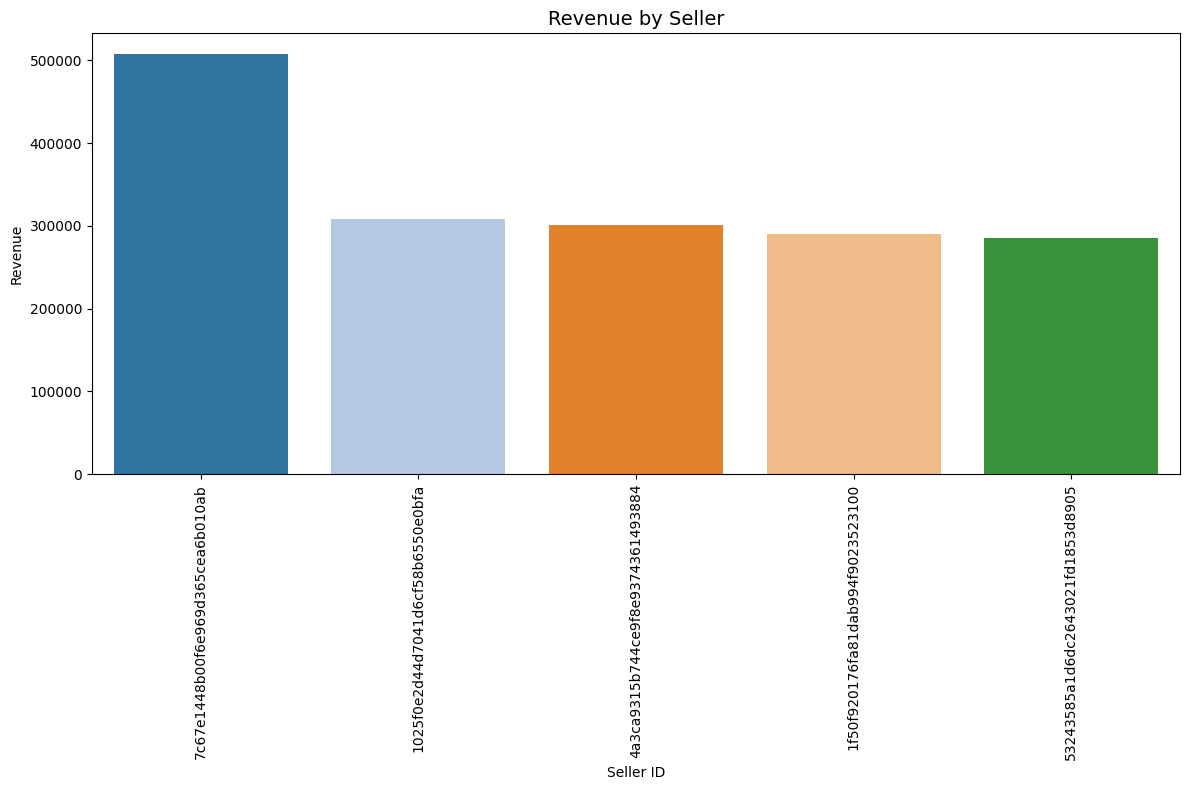

In [25]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    x='seller_id',
    y='revenue',
    hue='seller_id',  # Assigning hue to apply different colors
    data=df,
    palette='tab20',
    dodge=False
)

plt.xticks(rotation=90)
plt.title("Revenue by Seller", fontsize=14)
plt.xlabel("Seller ID")
plt.ylabel("Revenue")

# Hide the legend (do this after plotting)
ax.get_legend().remove()

# Optional: Add labels to bars
# for container in ax.containers:
#     ax.bar_label(container, fontsize=8, rotation=90)

plt.tight_layout()
plt.show()


## Calculate the moving average of order values for each customer over their order history.

In [26]:
query = """ 

SELECT customer_id, order_purchase_timestamp, payment,
avg(payment) OVER(PARTITION BY customer_id ORDER BY order_purchase_timestamp
					ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) AS mov_avg
FROM
(SELECT orders.customer_id, orders.order_purchase_timestamp,
payments.payment_value as payment
FROM payments JOIN orders
ON payments.order_id = orders.order_id) AS a

"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns= ["customer_id", "order_purchase_timestamp", "payment", "mov_avg"])
df

,customer_id,order_purchase_timestamp,payment,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.74
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.41
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.42
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.35
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.01
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.12
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.13
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.13
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.50


## Calculate the cumulative sales per month for each year.

In [27]:
query = """ 

SELECT 
    years, 
    months, 
    payment, 
    SUM(payment) OVER (ORDER BY years, months) AS cumulative_sales
FROM (
    SELECT 
        strftime('%Y', orders.order_purchase_timestamp) AS years,
        strftime('%m', orders.order_purchase_timestamp) AS months,
        ROUND(SUM(payments.payment_value), 2) AS payment
    FROM orders 
    JOIN payments ON orders.order_id = payments.order_id
    GROUP BY years, months
    ORDER BY years, months
) AS a


"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns=['years','months','payment','cumulative_sales'])
df


,years,months,payment,cumulative_sales
0,2016,09,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,01,138488.04,197850.38
4,2017,02,291908.01,489758.39
5,2017,03,449863.60,939621.99
6,2017,04,417788.03,1357410.02
7,2017,05,592918.82,1950328.84
8,2017,06,511276.38,2461605.22
9,2017,07,592382.92,3053988.14


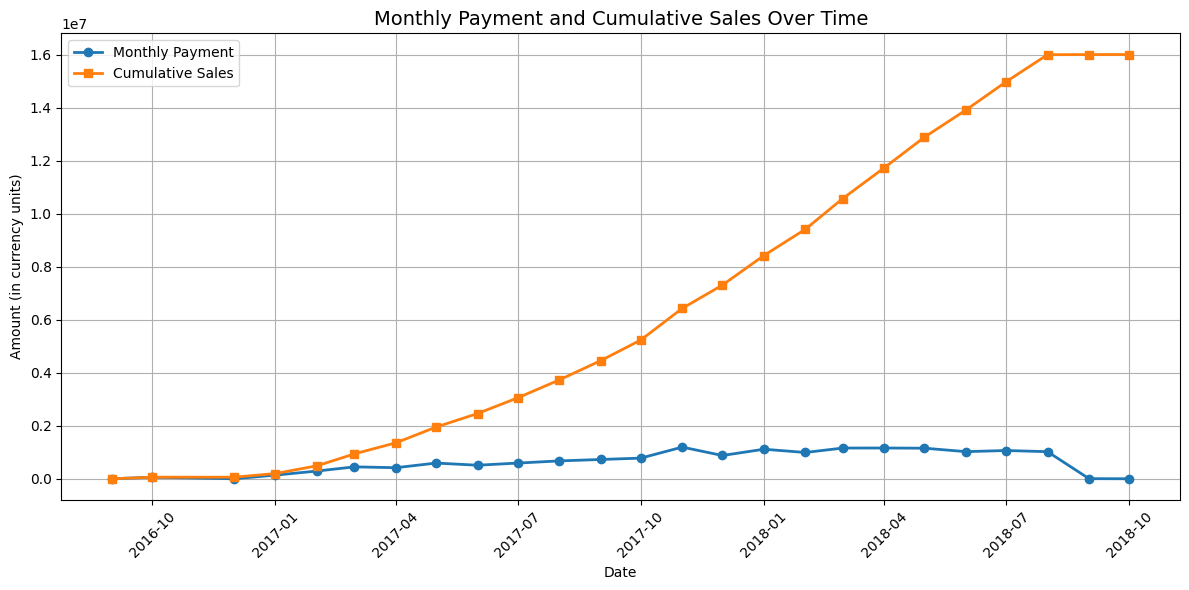

In [28]:
# Step 1: Create a proper datetime column
df['months'] = df['months'].str.zfill(2)  # Ensure '01', '02', ...
df['date'] = pd.to_datetime(df['years'] + '-' + df['months'] + '-01')

# Step 2: Clean data
df['payment'] = pd.to_numeric(df['payment'], errors='coerce')
df['cumulative_sales'] = pd.to_numeric(df['cumulative_sales'], errors='coerce')
df = df.replace([float('inf'), float('-inf')], pd.NA)
df = df.dropna(subset=['payment', 'cumulative_sales', 'date'])

# Step 3: Sort by date
df = df.sort_values('date')

# Step 4: Plot
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['payment'], label='Monthly Payment', marker='o', linewidth=2)
plt.plot(df['date'], df['cumulative_sales'], label='Cumulative Sales', marker='s', linewidth=2)

plt.title("Monthly Payment and Cumulative Sales Over Time", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Amount (in currency units)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Calculate the year-over-year growth rate of total sales.

In [29]:
query = """ 

WITH a AS (
  SELECT 
    strftime('%Y', orders.order_purchase_timestamp) AS years,
    ROUND(SUM(payments.payment_value), 2) AS payment
  FROM orders 
  JOIN payments ON orders.order_id = payments.order_id
  GROUP BY years 
  ORDER BY years
)
SELECT 
  years, 
  payment AS sales,
  LAG(payment) OVER (ORDER BY years) AS previous_year,
  CASE 
    WHEN LAG(payment) OVER (ORDER BY years) IS NULL THEN NULL
    ELSE ((payment - LAG(payment) OVER (ORDER BY years)) / LAG(payment) OVER (ORDER BY years)) * 100
  END AS yoy_percentage_growth
FROM a;


"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns=['years', 'sales', 'previous_year', 'yoy_percentage_growth'])

# Convert values to float
for col in ['sales', 'previous_year', 'yoy_percentage_growth']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Show cleanly with formatted output (avoids all warnings)
df.style.format({
    'sales': '{:,.2f}',
    'previous_year': '{:,.2f}',
    'yoy_percentage_growth': '{:+.2f}%'
})


,years,sales,previous_year,yoy_percentage_growth
0,2016,"59,362.34",nan,+nan%
1,2017,"7,249,746.73","59,362.34",+12112.70%
2,2018,"8,699,763.05","7,249,746.73",+20.00%


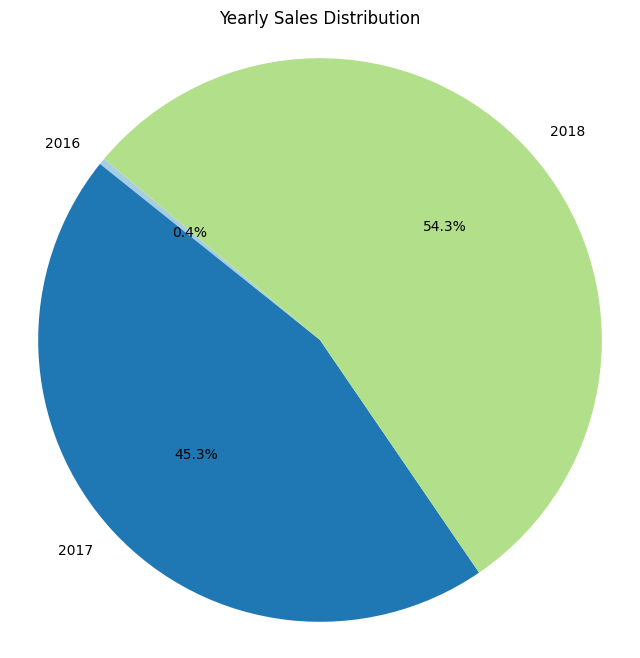

In [30]:
# Pie chart for yearly sales
plt.figure(figsize=(8, 8))
plt.pie(
    df['sales'], 
    labels=df['years'], 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=plt.cm.Paired.colors
)
plt.title('Yearly Sales Distribution')
plt.axis('equal')  # Equal aspect ratio ensures pie is a circle.
plt.show()

## Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase

In [31]:
query = """  

WITH a AS (
    SELECT customers.customer_id,
           MIN(orders.order_purchase_timestamp) AS first_order
    FROM customers 
    JOIN orders ON customers.customer_id = orders.customer_id
    GROUP BY customers.customer_id
),
b AS (
    SELECT a.customer_id, 
           COUNT(DISTINCT orders.order_purchase_timestamp) AS next_order
    FROM a 
    JOIN orders ON orders.customer_id = a.customer_id
        AND orders.order_purchase_timestamp > a.first_order
        AND orders.order_purchase_timestamp < DATE(a.first_order, '+6 months')
    GROUP BY a.customer_id
)

SELECT 
    100.0 * COUNT(DISTINCT b.customer_id) / COUNT(DISTINCT a.customer_id) AS percentage_customers_with_repeat_order_within_6_months
FROM a
LEFT JOIN b ON a.customer_id = b.customer_id;


"""

cur.execute(query)
data = cur.fetchall()

data

[(0.0,)]

In [32]:
query = """  

WITH a AS (
    SELECT customers.customer_id,
           MIN(orders.order_purchase_timestamp) AS first_order
    FROM customers 
    JOIN orders ON customers.customer_id = orders.customer_id
    GROUP BY customers.customer_id
),
b AS (
    SELECT a.customer_id, 
           COUNT(DISTINCT orders.order_purchase_timestamp) AS next_order
    FROM a 
    JOIN orders ON orders.customer_id = a.customer_id
        AND orders.order_purchase_timestamp > a.first_order
        AND orders.order_purchase_timestamp < DATE(a.first_order, '+6 months')
    GROUP BY a.customer_id
)

SELECT 
    CASE 
        WHEN COUNT(DISTINCT b.customer_id) = 0 OR COUNT(DISTINCT a.customer_id) = 0 THEN NULL
        ELSE 100.0 * COUNT(DISTINCT b.customer_id) / COUNT(DISTINCT a.customer_id)
    END AS percentage_customers_with_repeat_order_within_6_months
FROM a
LEFT JOIN b ON a.customer_id = b.customer_id;



"""

cur.execute(query)
data = cur.fetchall()

data

[(None,)]

- Since none of the customers are repeated thats why our value is None

## Identify the top 3 customers who spent the most money in each year.


In [33]:
query = """

SELECT years, customer_id, payment, d_rank 
FROM (
    SELECT 
        strftime('%Y', orders.order_purchase_timestamp) AS years,
        orders.customer_id,
        SUM(payments.payment_value) AS payment,
        DENSE_RANK() OVER (
            PARTITION BY strftime('%Y', orders.order_purchase_timestamp)
            ORDER BY SUM(payments.payment_value) DESC
        ) AS d_rank
    FROM orders 
    JOIN payments ON payments.order_id = orders.order_id
    GROUP BY years, orders.customer_id
) AS a
WHERE d_rank <= 3;


"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns= ['years', 'id', 'payment', 'rank'])

df

,years,id,payment,rank
0,2016,a9dc96b027d1252bbac0a9b72d837fc6,1423.55,1
1,2016,1d34ed25963d5aae4cf3d7f3a4cda173,1400.74,2
2,2016,4a06381959b6670756de02e07b83815f,1227.78,3
3,2017,1617b1357756262bfa56ab541c47bc16,13664.08,1
4,2017,c6e2731c5b391845f6800c97401a43a9,6929.31,2
5,2017,3fd6777bbce08a352fddd04e4a7cc8f6,6726.66,3
6,2018,ec5b2ba62e574342386871631fafd3fc,7274.88,1
7,2018,f48d464a0baaea338cb25f816991ab1f,6922.21,2
8,2018,e0a2412720e9ea4f26c1ac985f6a7358,4809.44,3


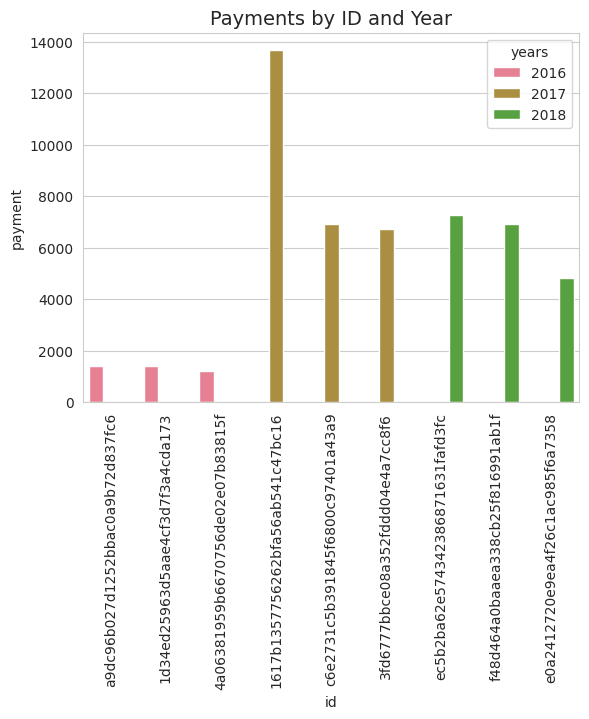

In [34]:
# Stylish color palette (Hue-Saturation-Lightness)

sns.set_style("whitegrid")  # Optional: cleaner background
sns.set_palette("husl")     # Stylish color palette (Hue-Saturation-Lightness)

sns.barplot(x="id", y="payment", data=df, hue="years")
plt.xticks(rotation=90)
plt.title("Payments by ID and Year", fontsize=14)

plt.show()

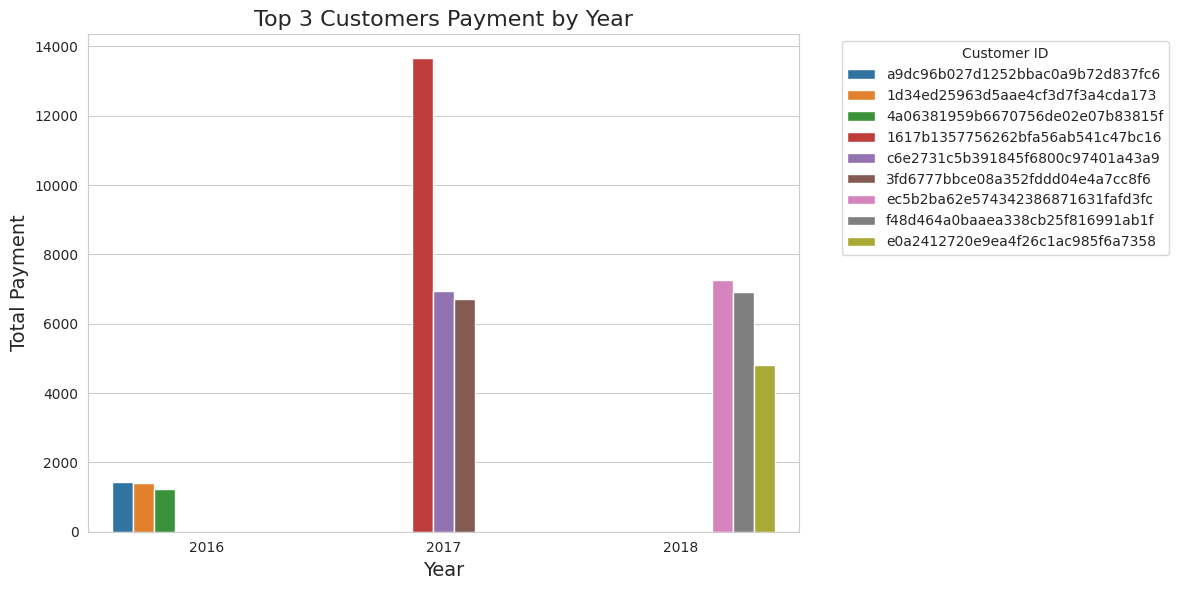

In [35]:
plt.figure(figsize=(12, 6))

# Bar plot with years on x-axis, payment on y-axis, grouped by customer_id
sns.barplot(
    x='years',
    y='payment',
    hue='id',          # Different color for each customer_id
    data=df,
    palette='tab10'    # Color palette
)

plt.title('Top 3 Customers Payment by Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Total Payment', fontsize=14)
plt.legend(title='Customer ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

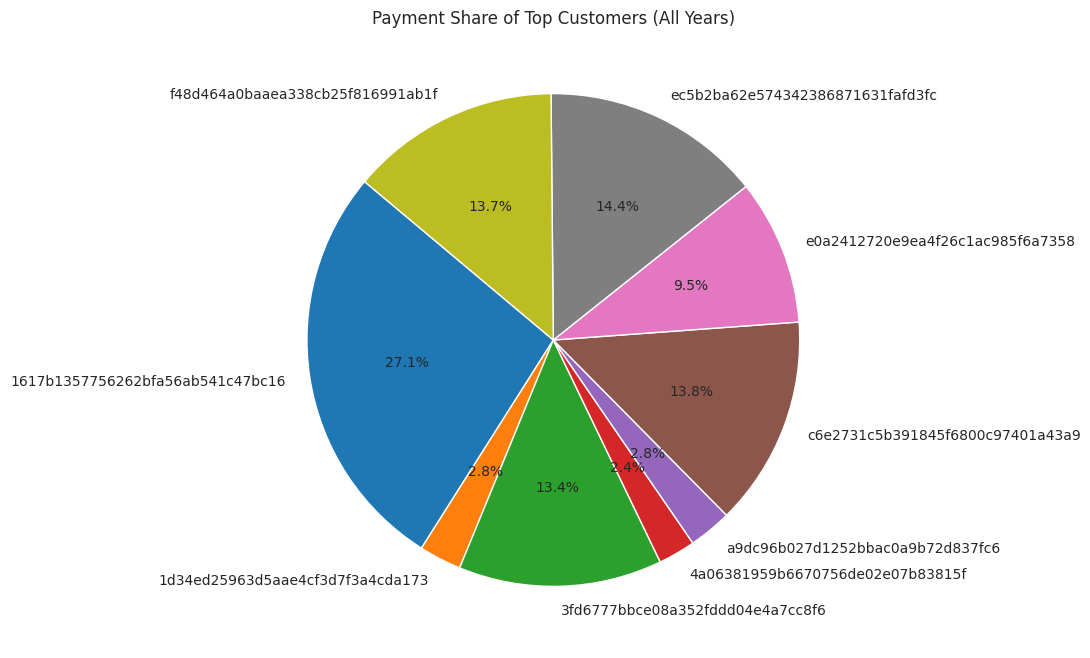

In [36]:
# Aggregate total payment per customer (across all years)
pie_data = df.groupby('id')['payment'].sum().reset_index()

plt.figure(figsize=(8, 8))
plt.pie(
    pie_data['payment'],
    labels=pie_data['id'],
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette('tab10', len(pie_data))
)
plt.title('Payment Share of Top Customers (All Years)')
plt.show()


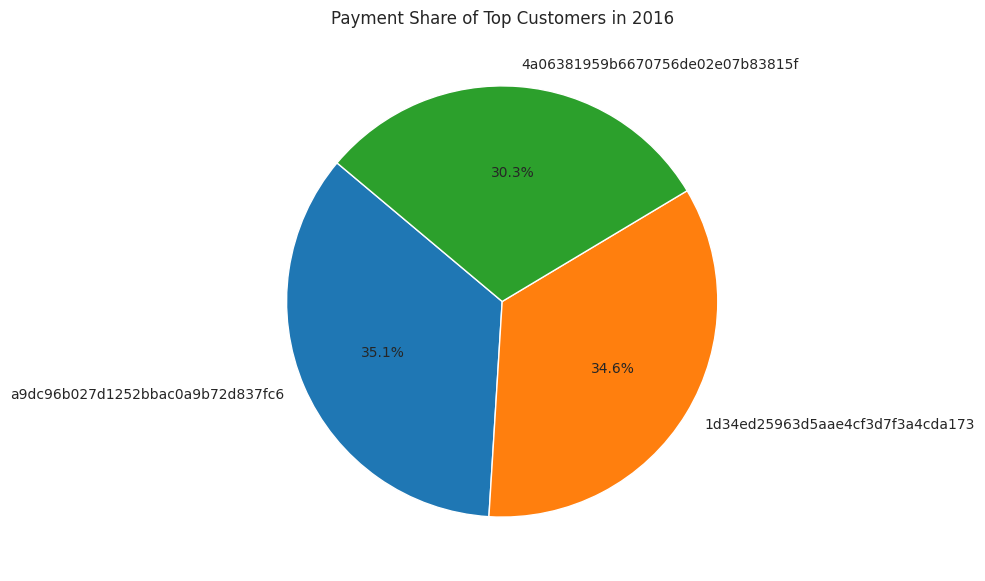

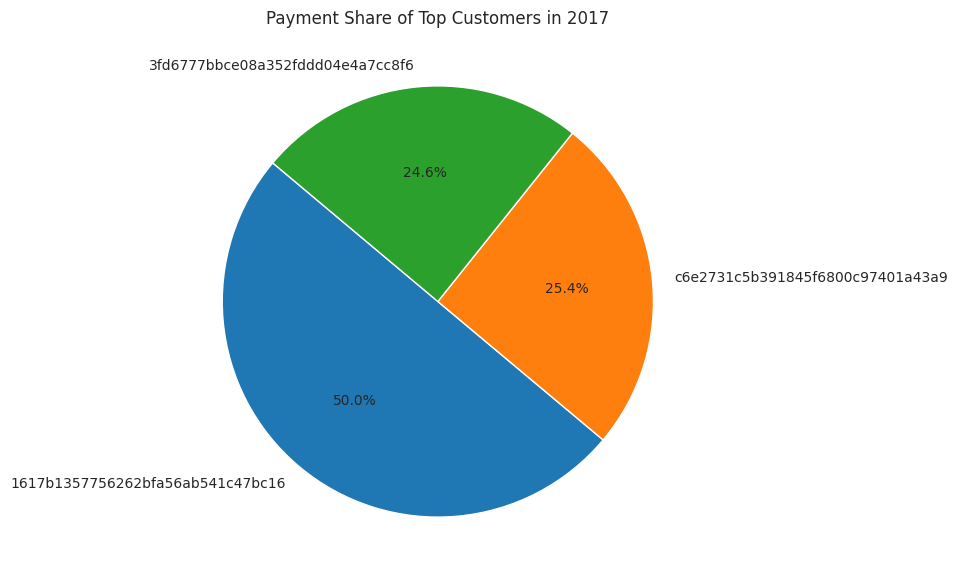

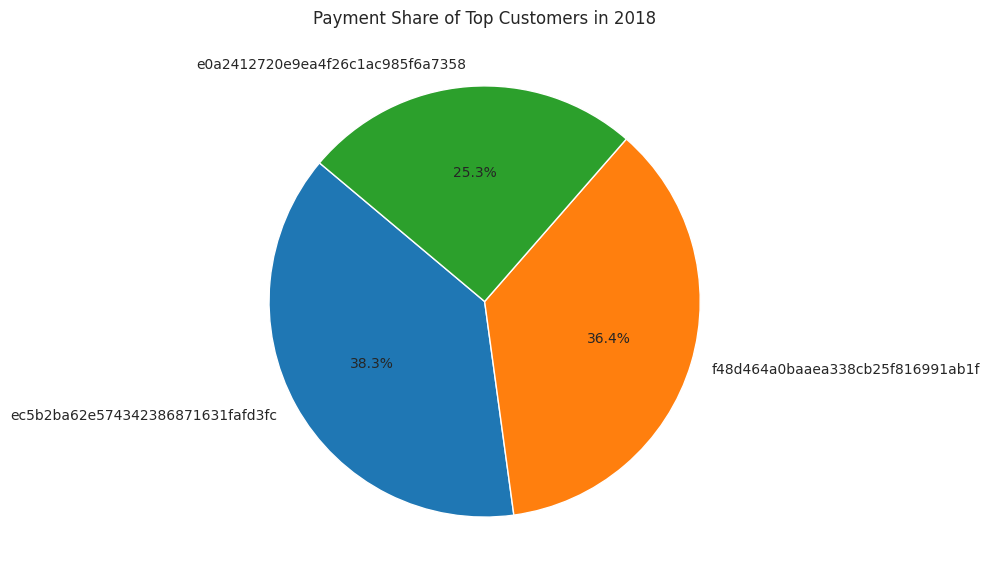

In [37]:
years = df['years'].unique()

for year in years:
    yearly_data = df[df['years'] == year].copy()
    plt.figure(figsize=(7, 7))
    plt.pie(
        yearly_data['payment'],
        labels=yearly_data['id'],
        autopct='%1.1f%%',
        startangle=140,
        colors=sns.color_palette('tab10', len(yearly_data))
    )
    plt.title(f'Payment Share of Top Customers in {year}')
    plt.show()
